# This notebook provides interactive widgets to play with the imaging requirements for the SKA1 SDP

## First, do the necessary set-up (run the code block below, first)

In [1]:
""" These first few lines below import the IPython definitions and methods that we will use. 
Please Refer to ipython_api.py for the implementation """
from IPython.html.widgets import interact, interactive, fixed
from IPython.html.widgets.interaction import interact_manual
from IPython.html import widgets
from api_ipython import SkaIPythonAPI as iapi
from parameter_definitions import *
from parameter_definitions import Constants as c
from implementation import Implementation as imp

%matplotlib inline

# The lines below define the available telescopes, bands and modes that may be chosen.

available_teles = (Telescopes.SKA1_Low, Telescopes.SKA1_Low_old, Telescopes.SKA1_Mid, Telescopes.SKA1_Mid_old, 
                   Telescopes.SKA1_Sur_old, Telescopes.SKA2_Low, Telescopes.SKA2_Mid)
available_bands = (Bands.Low, 
                   Bands.Mid1, Bands.Mid2, Bands.Mid5A, Bands.Mid5B, 
                   Bands.Sur1)
available_modes     = (ImagingModes.Continuum, ImagingModes.Spectral, ImagingModes.FastImg)
available_modes_all = (ImagingModes.Continuum, ImagingModes.Spectral, ImagingModes.FastImg, ImagingModes.All)
verbose_display = False

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Using default values, we can compare telescopes side-by-side

Telescope,SKA1_Mid_rebaselined,SKA1_Mid_rebaselined,
Band,Mid1,Mid1,
Mode,Continuum,Spectral,
Baseline Dependent Time Avg.,True,True,
Max Baseline,150000,150000,m
Max # channels,65536,65536,
Optimal Number of Facets,10,8,
Optimal Snapshot Time,1586.0,2334.1,sec.
Visibility Buffer,6,6,PetaBytes
Working (cache) memory,5.84e+05,8.92e+04,TeraBytes
Image side length,1.76e+04,1.22e+04,pixels


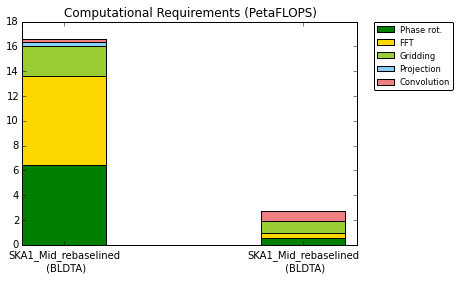

In [2]:
interact_manual(iapi.compare_telescopes_default, 
                telescope_1=available_teles, telescope_2=available_teles, band_1=available_bands,
                band_2=available_bands, mode_1=available_modes_all, mode_2=available_modes_all,
                verbose=verbose_display);

## We can also interactively play with parameters (via sliders)

### The first option is automatic updating of results as the sliders are moved. This may be sluggish

In [4]:
interact(iapi.evaluate_telescope_manual, max_baseline=(150000), Nf_max = (65536), Nfacet=(1,10,1), Tsnap=(1.2,1800), 
         telescope=available_teles, band=available_bands, mode=available_modes_all, verbose=verbose_display);

Max Baseline,150000 m
Max # of channels,65536
Telescope,SKA1_Mid_rebaselined
Band,Mid1
Mode,Continuum
Tsnap,310.1 sec
Nfacet,8


using Nfacet, facet_overlap: N_facet 0.2*sign(N_facet - 1)


Visibility Buffer,6.72 PetaBytes
Working (cache) memory,2.03 TeraBytes
Image side length,21944 pixels
I/O Rate,109 TeraBytes/s
Total Compute Requirement,43.6 PetaFLOPS
-> Gridding,0.905 PetaFLOPS
-> FFT,37 PetaFLOPS
-> Phase Rotation,0.209 PetaFLOPS
-> Projection,0.994 PetaFLOPS
-> Convolution,4.55 PetaFLOPS


### The second option is manual triggering of recompute events (recommended). 

#### This allows more conveniently computing elaborate (slow) optimizations and visualizations per computation, as these are only run when required
#### In this example, *Tsnap and Nfacet* are *automatically* chosen so as to minimize the value of Rflop

Max Baseline,150000 m
Max # of channels,64000
Telescope,SKA1_Mid_rebaselined
Band,Mid1
Mode,Fast Imaging


using Nfacet, facet_overlap: N_facet 0.2*sign(N_facet - 1)
Image Characteristics:
----------------------

Facet FOV:  0.0212206590789194*(0.787340649696*sign(N_facet - 1) + 3.93670324848)/N_facet  rads
PSF size:   5.71033253333e-06  rads
Pixel size: 1.90344417778e-06  rads
No. pixels on facet side: 11148.5586636399*(0.787340649696*sign(N_facet - 1) + 3.93670324848)/N_facet
Epsilon approx : 0.243733339110716
Found Qbw =    6.031, and cell frac error, epsilon,     0.244

---------------------

Channelization Characteristics:
-------------------------------

Ionospheric timescale (for updating kernels and limiting any time averaging):  10.0  sec
T_dump predict:  Min(1.2, 0.14*Max(1.0, floor(163193.646336675/Bmax,bin)))  sec
T_dump backward:  Min(10.0, 0.14*N_facet*Max(1.0, floor(163193.646336675/Bmax,bin))/(0.2*sign(N_facet - 1) + 1))  sec

No. freq channels for predict:  96934.7417005672
No. freq channels for backward step:  1.09861228866811/log(1 + 6.69254644637494*N_facet/(Bmax,bin*(0.

Optimal Number of Facets,1
Optimal Snapshot Time,1.0 sec.
Visibility Buffer,0 PetaBytes
Working (cache) memory,15.3 TeraBytes
Image side length,4.39e+04 pixels
I/O Rate,0.283 TeraBytes/s
Total Compute Requirement,58 PetaFLOPS
-> Gridding,0.111 PetaFLOPS
-> FFT,57.9 PetaFLOPS
-> Phase Rotation,0 PetaFLOPS
-> Projection,0 PetaFLOPS


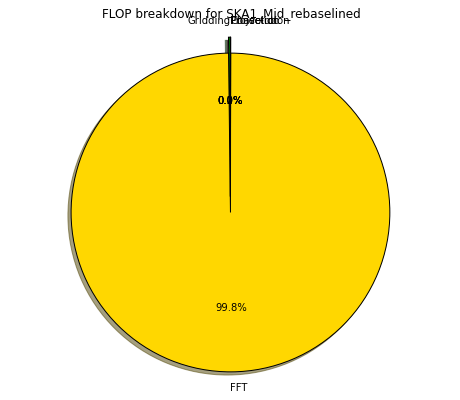

In [43]:
interact_manual(iapi.evaluate_telescope_optimized, max_baseline=(10000,200000,5000), Nf_max = (0,256000,4000), telescope=available_teles, 
         band=available_bands, mode=available_modes_all, verbose=verbose_display);

## illustrating 1D "parameter sweep" + visualization functionality.

Starting sweep of parameter Qkernel, evaluating expression Ncvff_predict over range (10, 11) in 1 steps (i.e. 2 data points)
Image Characteristics:
----------------------

Facet FOV:  0.0212206590789194*(1.574681299392*sign(N_facet - 1) + 7.87340649696)/N_facet  rads
PSF size:   5.71033253333e-06  rads
Pixel size: 1.14206650667e-06  rads
No. pixels on facet side: 18580.9311060665*(1.574681299392*sign(N_facet - 1) + 7.87340649696)/N_facet
Epsilon approx : 0.444175719318938
Found Qbw =    3.310, and cell frac error, epsilon,     0.444

---------------------

Channelization Characteristics:
-------------------------------

Ionospheric timescale (for updating kernels and limiting any time averaging):  10.0  sec
Coalesce Time predict:  Min(1.2, 0.14*Max(1.0, floor(148700.738918908/Bmax,bin)))  sec
Coalesce Time backward:  Min(10.0, 0.14*N_facet*Max(1.0, floor(148700.738918908/Bmax,bin))/(0.2*sign(N_facet - 1) + 1))  sec

No. freq channels for predict:  106382.295802026
No. freq channels for

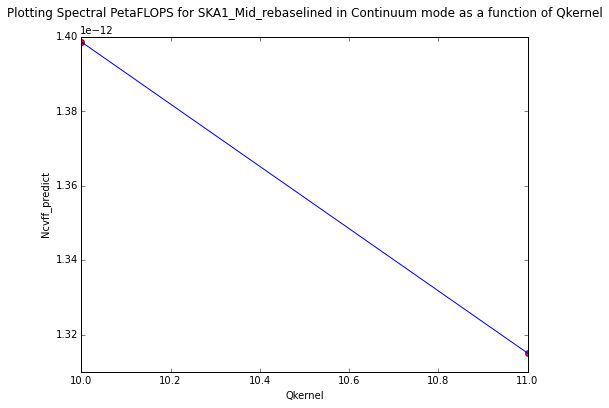

In [3]:
from IPython.display import display, HTML

expression = 'Ncvff_predict'
parameter = 'Qkernel'
param_val_min = 10
param_val_max = 11
number_steps = 1
telescope = Telescopes.SKA1_Mid
immode = ImagingModes.Continuum
band=Bands.Mid1

display(HTML('<font color="blue">Computing the result -- this may take several (tens of) seconds.</font>'))
(param_values, results) = iapi.eval_param_sweep_1d(telescope, immode, band=band, 
                                                   expression=expression, parameter=parameter, param_val_min=param_val_min,
                                                   param_val_max=param_val_max, number_steps=number_steps, verbose=True)
header = 'Plotting Spectral PetaFLOPS for %s in %s mode as a function of %s' % (telescope, immode, parameter)
iapi.plot_line_datapoints(header, param_values, np.array(results)/c.peta, xlabel=parameter, ylabel=expression)

## illustrating 2D "parameter sweep" + visualization functionality.

Evaluating expression Rflop while
sweeping parameters Qfov and Qkernel over 2D domain [0.9, 2.0] x [1, 11] in 1 steps each,
for a total of 4 data evaluation points
> 0.0% done: Evaluating Rflop for (Qfov, Qkernel) = (0.9, 1.0)
> 25.0% done: Evaluating Rflop for (Qfov, Qkernel) = (0.9, 11.0)
> 50.0% done: Evaluating Rflop for (Qfov, Qkernel) = (2.0, 1.0)
> 75.0% done: Evaluating Rflop for (Qfov, Qkernel) = (2.0, 11.0)
done with parameter sweep!


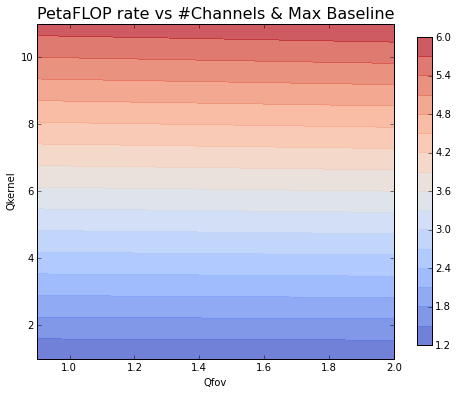

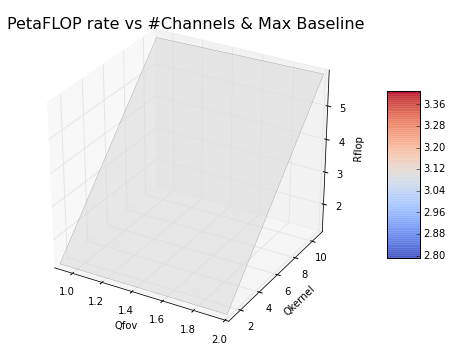

In [5]:
from IPython.display import display, HTML

telescope = Telescopes.SKA1_Low
band = Bands.Low
immode = ImagingModes.Spectral
expression = 'Rflop'
parameters = ('Qfov', 'Qkernel')
parameter_ranges = ((0.9,2.0),(1,11))
number_steps =1
verbose = False

display(HTML('<font color="blue">Computing the result -- this may take several (tens of) seconds.</font>'))
(p1_values, p2_values, results) = iapi.eval_param_sweep_2d(telescope, immode, band=band, 
                                                           expression=expression, parameters=parameters, 
                                                           params_ranges=parameter_ranges, number_steps=number_steps, 
                                                           verbose=verbose)


iapi.plot_2D_surface('PetaFLOP rate vs #Channels & Max Baseline', p1_values, p2_values, results/1e15, xlabel=parameters[0], 
                     ylabel=parameters[1], contours=np.array((0.5, 1.0)))
iapi.plot_3D_surface('PetaFLOP rate vs #Channels & Max Baseline', p1_values, p2_values, results/1e15, xlabel=parameters[0], 
                     ylabel=parameters[1], zlabel=expression, contours=np.array((0.5, 1.0)))